<h1>VQ-VAE</h1>
Rough idea: Autoencode an input image, here demonstrated on [3 x 32 x 32] images, but express the latent code not as continous values,<br/>
but as quantised values (i.e. indices in a codebook).<br/>
Technically, this is pretty similar to applying K-means to the latent space, with the centroid being the "codewords"; we then simply round the codewords to the nearest centroid.<br/>
The paper recommends using EMA to update the codebook (=move each codeword a bit towards the average of the elements that fall into that codeword)<br/>
I added a tiny extra loss that makes sure our codebook is normal distributed, leading to much better use of the codewords (=fewer unused codewords) and hence, better performance
<br/>
<font color="red"><b>WARNING:</b></font> The results here are a bit blurry! VQVAE performs pretty bad on small images (CIFAR) when going from 32-by-32 to 8-by-8, i.e. with a compression rate of turning a 4-by-4 block into ONE token.<br/>
For larger images, results look okay-ish (=less structure gets mashed together; if we have 256p images of a fish, then the scales don't have to look crisp for the image to be crisp when using a factor of four like here). This is just a demonstration! Toy around, throw one downscaling out (=do 16-by-16), use more codewords, etc., to make things look better!<br/>
<br/>
Applications for this include e.g. autoregressive probabilistic generation. We can also sharpen a VQ-VAE with an additional discriminator ("VQGAN"), i.e. reconstructing lost details by "imagining" something new. Works particularly great in high resolution images (not so much on e.g. CIFAR), as there are a lot of details that are not important; on CIFAR, every single pixel is needed for structure anyway; but e.g. on high-res images of fishes, VQGAN is great at learning e.g. the patterns of their scales instead of just outputting some "averaged" colour for the area<br/>
<br/>
Literature I recommend:<br/>
1. VQ-VAE:  https://arxiv.org/abs/1711.00937<br/>
2. VQGAN: https://arxiv.org/abs/2012.09841<br/>
3. Improved VQGAN: https://arxiv.org/abs/2310.05400 (uses a Wasserstein discriminator and makes sure all codewords are used properly)<br/>

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import time
import torch.nn as nn
import math
import numpy as np
from torchvision.utils import save_image
import platform
import sys
import os
import matplotlib.pyplot as plt
import torchvision

#nobody likes scientific rep...
torch.set_printoptions(precision=6, sci_mode=False)

Files already downloaded and verified
Files already downloaded and verified


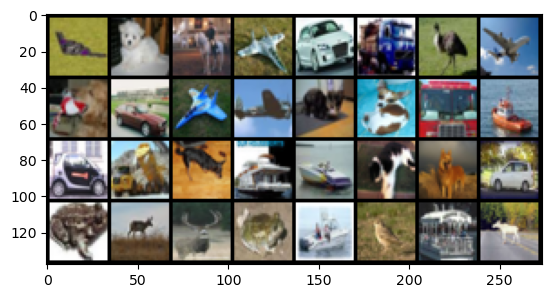

In [2]:
transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

def imshow(img):
    npimg = img.clamp(0.0, 1.0).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for images, labels in trainloader:
    imshow(torchvision.utils.make_grid(images))
    break

In [3]:
VQVAE_D = 64 #number of dimensions in quantised space, i.e. the number of dimensions in which we cluster (round in [b x VQVAE_D x W X H] in dimension 1 to the nearest centroid (i.e. codeword))
# rule of thumb: VQVAE_D should be at least such that CODEWORDS <= 2**VQVAE_D to ensure that the quantised space is large enough to capture the variance in the data;
# trivial example: if we use VQVAE_D = 1, then we can only cluster the data in one dimension, which doesn't work that well as networks are good at doing binary decisions, but not good at doing decisions with 512 different options
# if we use e.g. 4 dimensions, then we can do 4 binary decisions with our relus, hence we have 16 different options - better than 1, but still not enough for 512 different options (=CODEWORDS)
VQVAE_K = 512 #number of codewords in the codebook, i.e. the number of centroids in the quantised space

CONV NET HAS  1522435  PARAMS
*** DONE WITH EPOCH  0 ***
	Train loss: rec= 0.018523263092547825 , code= 0.012511820694156376 , comm= 0.012511820694156376 ; BONUS: distrib= 0.5707255444767684


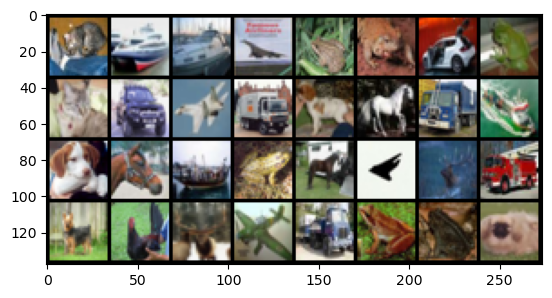

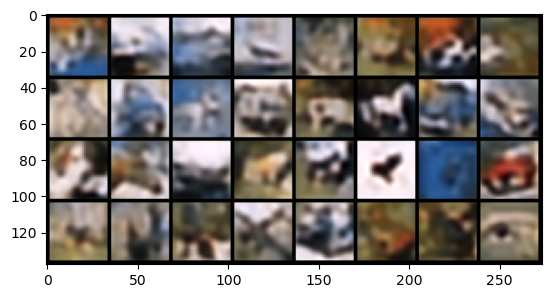

	The test set has seen  13 / 512  unique indices
	Test loss: rec= 0.009517933652638056 , code= 0.0006742693748389461 , comm= 0.0006742693748389461
*** DONE WITH EPOCH  1 ***
	Train loss: rec= 0.00792083726815703 , code= 0.0024139062558543307 , comm= 0.0024139062558543307 ; BONUS: distrib= 0.5524864392599386


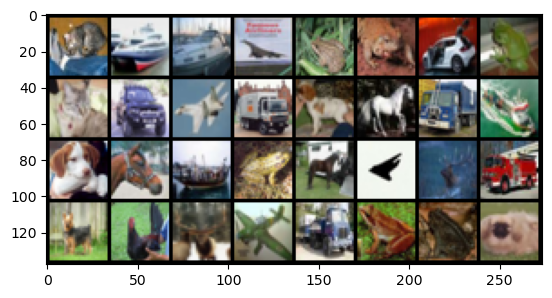

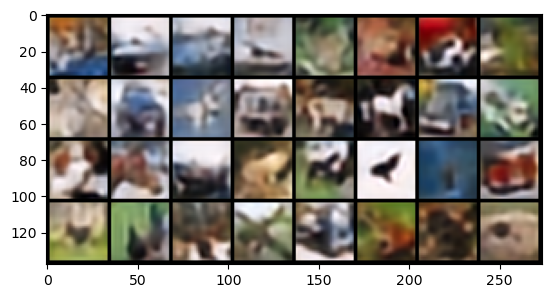

	The test set has seen  46 / 512  unique indices
	Test loss: rec= 0.006783516013834138 , code= 0.0003705402708541476 , comm= 0.0003705402708541476


KeyboardInterrupt: 

In [4]:
class BaseAE(nn.Module):
    def __init__(self, c_in):
        super(BaseAE, self).__init__()

        CHANNELS = 256

        self.relu = torch.nn.LeakyReLU() #we use leaky relu as activation function, as it also has a gradient for an input < 0
        self.reduce = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.conv_res = torch.nn.Conv2d(in_channels=c_in, out_channels=VQVAE_D, kernel_size=1, stride=1, padding=0, bias=False)

        #super basic encoder (convolution -> relu -> pooling -> repeat), to improve: replace conv2d with a full residual block and add some normalisation
        #we don't use strided convolution to reduce the spatial dimensions, but instead use pooling, as this usually avoids checkerboard artefacts: https://distill.pub/2016/deconv-checkerboard/
        self.encoder = nn.Sequential()
        self.encoder.append(torch.nn.Conv2d(in_channels=c_in, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1))
        self.encoder.append(self.relu)
        self.encoder.append(self.reduce)
        self.encoder.append(torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1))
        self.encoder.append(self.relu)
        self.encoder.append(self.reduce)
        self.encoder.append(torch.nn.Conv2d(in_channels=CHANNELS, out_channels=VQVAE_D, kernel_size=3, stride=1, padding=1))
        
        #same for the decoder, but with upsampling instead of pooling. same as above, no transposed convolutions, but upsampling, as this usually avoids checkerboard artefacts
        self.decoder = nn.Sequential()
        self.decoder.append(torch.nn.Conv2d(in_channels=VQVAE_D, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1))
        self.decoder.append(self.relu)
        self.decoder.append(torch.nn.Upsample(scale_factor=2, mode='bilinear'))
        self.decoder.append(torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1))
        self.decoder.append(self.relu)
        self.decoder.append(torch.nn.Upsample(scale_factor=2, mode='bilinear'))
        self.decoder.append(torch.nn.Conv2d(in_channels=CHANNELS, out_channels=c_in, kernel_size=3, stride=1, padding=1))
        self.decoder.append(self.relu) #we have [0, 1] for our data (not [-1, 1]), so we CAN use a relu; if we'd normalise data, this would kill of negative values (which we don't have)

        #this is the values we round to, i.e. the "centroids" in the quantised space
        #little trick to get better initialisation:
        #   if we get values far away from any encoder outputs by chance, we have no gradient to these codewords
        #   hence, rather set the codewords a bit "closer" around the centre, so we have a gradient for all codewords 
        self.codebook = torch.nn.Parameter((torch.rand(VQVAE_K, VQVAE_D) * 2.0 - 1.0) * 0.5, requires_grad=True)

    def quantise(self, x):
        #this is where the magic happens:
        #    1. take input of size [b x W x H x VQVAE_D] and reshape to [b x W x H x VQVAE_D];
        #       this means we have ALL the codewords in the last dimension now, so we can just merge together all other dimensions to easily compare them to the codewords
        x = x.permute(0, 2, 3, 1).contiguous()
        size_in = x.size()
        x = x.view(-1, VQVAE_D)
        #   2. compare [b*W*H x VQVAE_D] to [CODEWORDS x VQVAE_D]: by re-shaping to have [b*W*H x 1 x VQVAE_D] and [1 x CODEWORDS x VQVAE_D], the substraction will
        #      give us a [b*W*H x CODEWORDS X VQVAE_D] tensor of all distance pairs between input elements (b*W*H) and the CODEWORDS-many codewords; just square, 
        #      then sum up the last dimension to get sum of the distance values for each dimension (=euclidean squared distance)
        #      and then take the argmin to get the index of the closest codeword for each input element - these are our indices we want!
        indices = (x[:,None] - self.codebook.view(1, VQVAE_K, VQVAE_D)).square().sum(dim=2).argmin(dim=1)
        #   3. we take those indices we just looked up: these are the indices of the closest codeword for each input element, so we can now look up the actual 
        #      codeword to find the closest codeword to each input element aka the "centroids" we round to
        x_rounded = self.codebook[indices]
        
        #   4. we calculate the loss for the commitment loss (i.e. does the encoder produce stuff from the codebook?) and the codebook loss (how close is the codebook to the encoder outputs?)
        #      the value is exactly the same for both terms, but this way we can a) train encoder and codebook with different magnitudes and b) the encoder outputs and codebook outputs are
        #      not just "shrinked" to one super tiny value: the loss we be almost zero if codebook and encoder outputs would be just downscaled by some tiny factor (latent space just shrinks together)
        #      to avoid that, we use the detach() function, making sure that codebook and encoder outputs move individually and not just shrink together to something tiny
        loss_commitment = (x - x_rounded.detach()).square().mean() #only have gradient for encoder 
        loss_codebook   = (x.detach() - x_rounded).square().mean()   #only have gradient for codebook

        #   5. the actual rounding we do: we take the difference between the rounded and the unrounded value and add it to the unrounded value
        #      the paper calls this "straight through estimator", as we just pass the gradient through the rounding operation (which is not differentiable)
        #      what essentially happens here is that we just take our x and substract some float without any gradient, similar to writing "x = x - 0.1":
        #      "(x - x_rounded).detach()" becomes just some number that we substract from x; this converts x to the same values as x_rounded, but the gradient is not passed through this operation
        #      i.e. we round, but keep the (then a bit inexact) gradient 
        x = x - (x - x_rounded).detach() #change x to x_rounded, but keep the gradient from x

        #   6. we reshape back to the original shape and return the values; we also return both losses and the indices of the closest codewords
        x = x.view(size_in)
        x = x.permute(0, 3, 1, 2).contiguous()
        return x, loss_codebook, loss_commitment, indices.view(x.size()[0], x.size()[2], x.size()[3])
    
    def forward(self, x):
        #encode, then quantise, then decode; pass the codebook loss and commitment loss through so we can use them for training
        w, h = x.size()[2], x.size()[3]
        x_res = self.conv_res(self.reduce(self.reduce(x))) #simple residual connection; makes optimisation more stable
        x = self.encoder(x)
        x = x + x_res
        x, loss_codebook, loss_commitment, indices = self.quantise(x)
        x = self.decoder(x)
        return x, loss_codebook, loss_commitment, indices

#pretty much standard for everything else - put data through, train, that's it
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BaseAE(c_in=3).to(DEVICE)
print("CONV NET HAS ", sum(p.numel() for p in net.parameters() if p.requires_grad), " PARAMS")
optim = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.01)

for epoch in range(0, 100):
    avg_losses = [0, 0, 0, 0]
    for data, labels in trainloader:
        optim.zero_grad()
        data = data.to(DEVICE)

        outputs, loss_codebook, loss_commitment, indices = net(data)
        #indices are the indices of the closest codewords for each input element;
        #hence we have [8 x 8] int values in [0, 512) for each image in the batch
        #if we just write them one after the other, as 64 values, we can e.g. train a transformer
        #on them to learn to autoregressively generate these codewords to produce something we can decode into an image

        loss_reconstruction = (outputs - data).square().mean()
        #loss is composed of reconstruction (=input should be output), codebook (=codebook should be close to encoder outputs) and commitment loss (encoder outputs should be close to the codebook values)
        #instead of 0.25, you can also use 2.0 or something, does not matter too much



        #additionally: make sure the codebook is roughly a normal distribution
        #              as this drags codewords towards a normal distribution, it can help to avoid "dead" codewords
        #              we only apply this loss with a very small magnitude
        #              this is NOT part of the original VQVAE paper, but increases performance significantly!
        normal_distr = torch.randn(VQVAE_K, VQVAE_D, device=DEVICE)
        #find the closest codeword to each normal distribution value; then minimise the distance between the normal distribution value and the closest codeword
        loss_distrib = (net.codebook[:,None] - normal_distr[None]).square().mean(dim=2).min(dim=1)[0].mean()


        loss = loss_reconstruction + loss_codebook * 0.25 + loss_commitment + 0.001 * loss_distrib
        loss.backward()
        avg_losses[0] += loss_reconstruction.item()
        avg_losses[1] += loss_codebook.item()
        avg_losses[2] += loss_commitment.item()
        avg_losses[3] += loss_distrib.item()
        optim.step()

    print("*** DONE WITH EPOCH ", epoch, "***")
    print("\tTrain loss: rec=", avg_losses[0] / len(trainloader),", code=", avg_losses[1] / len(trainloader),", comm=", avg_losses[2] / len(trainloader),"; BONUS: distrib=", avg_losses[3] / len(trainloader))
    #also run the test set through the network
    avg_losses = [0, 0, 0]
    step = 0
    #track unique indices:
    unique_indices = set()
    for data, labels in testloader:
        data = data.to(DEVICE)
        outputs, loss_codebook, loss_commitment, indices = net(data)
        loss_reconstruction = (outputs - data).square().mean()
        avg_losses[0] += loss_reconstruction.item()
        avg_losses[1] += loss_codebook.item()
        avg_losses[2] += loss_commitment.item()

        #count unique indices:
        unique_indices.update(torch.unique(indices).tolist())
        #make sure unique indices stay unique
        unique_indices = set(unique_indices)
        #show the first item from the testset

        if step == 0:
            imshow(torchvision.utils.make_grid(data.cpu()))
            imshow(torchvision.utils.make_grid(outputs.cpu().detach()))
            step += 1
    print("\tThe test set has seen ", len(unique_indices), "/",VQVAE_K," unique indices") #should be somewhat close to VQVAE_K; else use some techniques to either re-initialise the codebook or regularise the encoder distribution
    print("\tTest loss: rec=", avg_losses[0] / len(testloader),", code=", avg_losses[1] / len(trainloader),", comm=", avg_losses[2] / len(trainloader))